<img src="./images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Classical Optimization*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the Quantum Experience consult the [Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0) or check-out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Jay Gambetta, Antonio Mezzacapo

## Introduction

Many problems in finance and optimization can be casted into classical Ising models. Here we show a method that is very similar to Ref. [Fahri] for finding the ground state of the Ising problem using short depth quantum circuits. 

Here we propose that we map the cost function of the problem to a Hamiltonian of the form

$$ H_\mathrm{Ising} = \alpha_i Z_i + \beta_{i,j} Z_jZ_i$$

and the goal is to find the configuration that minimizes the energy.


Pseudo code

```
set the maximul control updates max_trials 
set initial controls u
loop through the max_trials
    prepare trial state |psi(u)> 
    
    Evaluate cost funtion C = <H> 
    
    Evaluate grad_u C (control update direction)
    
    update controls u -> u - grad_u C
    
    break if you find a good solution
    
return |<z|psi>|^2
```

The trial functions we propose using are of the form 

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a function of cPhase gates and $U_\mathrm{single}(\theta) = Y(\theta)^{\otimes n}$ where $n$ is the number of qubits and $m$ is the depth of the quantum circuit.

This can esaily be extended 

$$H = H_\mathrm{Ising}+ \gamma_{i,j,k}Z_kZ_jZ_i +... $$ 

and below we have show how different problems can be mapped to the Ising model.

ADD

In [1]:
# Checking the version of PYTHON we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
# usefull additional packages 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
%matplotlib inline
import time

# importing the QX and QISKit 
from IBMQuantumExperience import IBMQuantumExperience
import sys
sys.path.append("..")
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.extensions.standard import x, h, cx, s, u3, barrier, cz

# some usefull functions for running a program, plotting, and getting the data
from qhelpers.misc import run_program
from qhelpers.misc import program_to_text
from qhelpers.misc import combine_jobs
from qhelpers.misc import get_data
from qhelpers.basicplotter import plot_histogram
from qhelpers.misc import average_data
from tools.quantum_optimization import cost_classical
from tools.quantum_optimization import trial_funtion_optimization


# set up the api to communitcate to the QX
import Qconfig
api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken, Qconfig.config)

Enter the cost function below that you would like to minimize

In [2]:
# cost function H = alpha_i z_i + beta_ij z_i z_j
alpha = np.zeros(5)
alpha[4] = 1
beta = np.zeros((5, 5))
beta[0, 1] = 0.5
beta[1, 0] = 0.5
beta[0, 2] = 0.5
beta[2, 0] = 0.5
beta[1, 2] = 0.5
beta[2, 1] = 0.5
beta[1, 3] = 0.5
beta[3, 1] = 0.5
beta[2, 3] = 0.5
beta[3, 2] = 0.5

## Simulation

In [3]:
# making a classical trial function 
n=5 # number of qubits
device = 'simulator' # the device to run on
shots = 1024    # the number of shots in the experiment. 

q = QuantumRegister("q", n)
c = ClassicalRegister("c", n)
trial_circuit = QuantumCircuit(q, c)
trial_circuit.x(q[0])
trial_circuit.x(q[3])
trial_circuit.x(q[4])
for j in range (n):
    trial_circuit.measure(q[j], c[j])


# running the program
program = [trial_circuit]
out = run_program(program,api,device,shots,max_credits=3)
results=combine_jobs([out['id']], api, wait=20, timeout=240) 

# calculating the cost for this trial function
cost_classical(get_data(results,0),n,alpha,beta)

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


-4.0

In [4]:
# making a quantum trial function 
m = 1 # the depth 
entangler_map = {0: [2], 1: [2], 3: [2], 4: [2]} # the map of two qubit gates with control at key and target at values
theta = np.zeros(m*n) #the single qubit Y rotation angle 
trial_circuit = trial_funtion_optimization(n,m,theta,entangler_map) # generating the trial function
 
# running the program
program = [trial_circuit]
out = run_program(program,api,device,shots,max_credits=3)
results=combine_jobs([out['id']], api, wait=20, timeout=240)  

# calculating the cost for this trial function
cost_classical(get_data(results,0),n,alpha,beta)

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


-0.05078125

In [5]:
# quantum circuit parameters
device = 'simulator' # the device to run on
shots = 8192    #the number of shots in the experiment. 
n=5 # number of qubits
entangler_map = {0: [2], 1: [2], 3: [2], 4: [2]} # the map of two qubit gates with control at key and target at values

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 100;
theta_depth_1 = np.random.randn(1*n) # intial controls 
theta_depth_2 = np.random.randn(2*n) # intial controls 
theta_depth_3 = np.random.randn(3*n) # intial controls 

cost_plus_depth_1=np.zeros(max_trials)
cost_minus_depth_1=np.zeros(max_trials)
cost_plus_depth_2=np.zeros(max_trials)
cost_minus_depth_2=np.zeros(max_trials)
cost_plus_depth_3=np.zeros(max_trials)
cost_minus_depth_3=np.zeros(max_trials)

for k in range(max_trials):
    print('trial ' + str(k) + " of " + str(max_trials))
    a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
    c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

    Delta_depth_1 = 2*np.random.randint(2,size=n*1)-1 # \pm 1 random distribution 
    Delta_depth_2 = 2*np.random.randint(2,size=n*2)-1 # \pm 1 random distribution 
    Delta_depth_3 = 2*np.random.randint(2,size=n*3)-1 # \pm 1 random distribution 
    
    theta_plus_depth_1 = theta_depth_1 + c_spsa*Delta_depth_1
    theta_minus_depth_1 = theta_depth_1 - c_spsa*Delta_depth_1
    theta_plus_depth_2 = theta_depth_2 + c_spsa*Delta_depth_2
    theta_minus_depth_2 = theta_depth_2 - c_spsa*Delta_depth_2
    theta_plus_depth_3 = theta_depth_3 + c_spsa*Delta_depth_3
    theta_minus_depth_3 = theta_depth_3 - c_spsa*Delta_depth_3

    trial_circuit_plus_depth_1 = trial_funtion_optimization(n,1,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_1 = trial_funtion_optimization(n,1,theta_minus_depth_1,entangler_map) 
    trial_circuit_plus_depth_2 = trial_funtion_optimization(n,2,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_2 = trial_funtion_optimization(n,2,theta_minus_depth_2,entangler_map)
    trial_circuit_plus_depth_3 = trial_funtion_optimization(n,3,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_3 = trial_funtion_optimization(n,3,theta_minus_depth_3,entangler_map)
    
    program = [trial_circuit_plus_depth_1,trial_circuit_minus_depth_1,trial_circuit_plus_depth_2
               ,trial_circuit_minus_depth_2,trial_circuit_plus_depth_3,trial_circuit_minus_depth_3]
    out = run_program(program,api,device,shots,max_credits=3)
    results=combine_jobs([out['id']], api, wait=20, timeout=240)
    
    cost_plus_depth_1[k] = cost_classical(get_data(results,0),n,alpha,beta)
    cost_minus_depth_1[k] = cost_classical(get_data(results,1),n,alpha,beta)
    cost_plus_depth_2[k] = cost_classical(get_data(results,2),n,alpha,beta)
    cost_minus_depth_2[k] = cost_classical(get_data(results,3),n,alpha,beta)
    cost_plus_depth_3[k] = cost_classical(get_data(results,4),n,alpha,beta)
    cost_minus_depth_3[k] = cost_classical(get_data(results,5),n,alpha,beta)
    
    g_spsa_depth_1 = (cost_plus_depth_1[k]-cost_minus_depth_1[k])*Delta_depth_1/(2.0*c_spsa)
    g_spsa_depth_2 = (cost_plus_depth_2[k]-cost_minus_depth_2[k])*Delta_depth_2/(2.0*c_spsa)
    g_spsa_depth_3 = (cost_plus_depth_3[k]-cost_minus_depth_3[k])*Delta_depth_3/(2.0*c_spsa)

    theta_depth_1 = theta_depth_1 - a_spsa*g_spsa_depth_1
    theta_depth_2 = theta_depth_2 - a_spsa*g_spsa_depth_2
    theta_depth_3 = theta_depth_3 - a_spsa*g_spsa_depth_3

trial_circuit_depth_1 =  trial_funtion_optimization(n,1,theta_depth_1,entangler_map) 
trial_circuit_depth_2 =  trial_funtion_optimization(n,2,theta_depth_2,entangler_map) 
trial_circuit_depth_3 =  trial_funtion_optimization(n,3,theta_depth_3,entangler_map) 

program = [trial_circuit_depth_1,trial_circuit_depth_2,trial_circuit_depth_3]
out = run_program(program,api,device,shots,max_credits=3)
results=combine_jobs([out['id']], api, wait=20, timeout=240)  
cost_depth_1 = cost_classical(get_data(results,0),n,alpha,beta)
cost_depth_2 = cost_classical(get_data(results,1),n,alpha,beta)
cost_depth_3 = cost_classical(get_data(results,2),n,alpha,beta)
print('m=1 ' + str(cost_depth_1) + ' m=2 ' + str(cost_depth_2) + 'm=3 ' + str(cost_depth_3))

trial 0 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 1 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 2 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 3 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 4 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 5 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 6 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 7 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 8 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 9 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 10 of 100
status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)
trial 11 

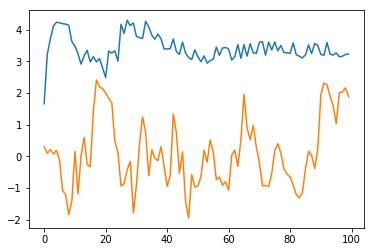

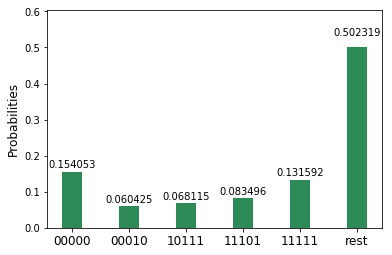

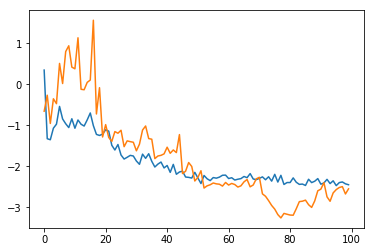

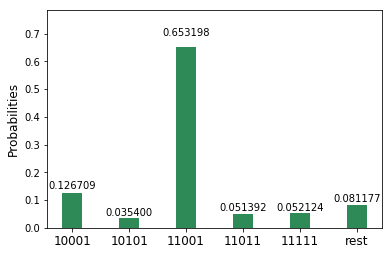

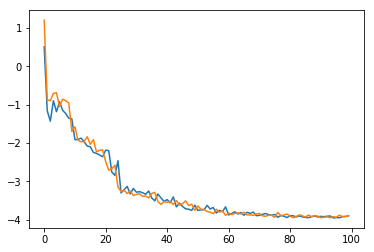

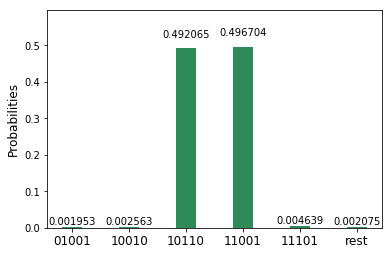

In [6]:
# plotting up data
plt.plot(range(max_trials), cost_plus_depth_1, range(max_trials), cost_minus_depth_1)
plot_histogram(get_data(results,0),n)
plt.plot(range(max_trials), cost_plus_depth_2, range(max_trials), cost_minus_depth_2)
plot_histogram(get_data(results,1),n)
plt.plot(range(max_trials), cost_plus_depth_3, range(max_trials), cost_minus_depth_3)
plot_histogram(get_data(results,2),n)

## Real

In [21]:
# making a classical trial function 
n=5 # number of qubits
device = 'real' # the device to run on
shots = 8192    # the number of shots in the experiment. 
max_credits=5

q = QuantumRegister("q", n)
c = ClassicalRegister("c", n)
trial_circuit = QuantumCircuit(q, c)
trial_circuit.x(q[0])
trial_circuit.x(q[3])
trial_circuit.x(q[4])
for j in range (n):
    trial_circuit.measure(q[j], c[j])

print(trial_circuit.qasm())
    
# running the program
program = [trial_circuit]
out = run_program(program,api,device,shots,max_credits)
results=combine_jobs([out['id']], api, wait=20, timeout=240) 

# calculating the cost for this trial function
cost_classical(get_data(results,0),n,alpha,beta)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
x q[0];
x q[3];
x q[4];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];

status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (20 seconds)
status = {'RUNNING': 1} (40 seconds)
status = {'COMPLETED': 1} (60 seconds)


-2.853515625

In [23]:
# making a quantum trial function 
m = 1 # the depth 
entangler_map = {0: [2], 1: [2], 3: [2], 4: [2]} # the map of two qubit gates with control at key and target at values
theta = np.zeros(m*n) #the single qubit Y rotation angle 
trial_circuit = trial_funtion_optimization(n,m,theta,entangler_map) # generating the trial function
 
# running the program
program = [trial_circuit]
out = run_program(program,api,device,shots,max_credits)
results=combine_jobs([out['id']], api, wait=20, timeout=240)  

# calculating the cost for this trial function
cost_classical(get_data(results,0),n,alpha,beta)

status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (20 seconds)
status = {'RUNNING': 1} (40 seconds)
status = {'COMPLETED': 1} (60 seconds)


0.46875

In [48]:
# quantum circuit parameters
device = 'real' # the device to run on
shots = 8192    #the number of shots in the experiment. 
n=5 # number of qubits
entangler_map = {0: [2], 1: [2], 3: [2], 4: [2]} # the map of two qubit gates with control at key and target at values
max_credits = 5

# Numerical parameters 
SPSA_parameters = np.array([.3,0.602,0,.1,0.101]) #[a, alpha, A, c, gamma]
max_trials = 50;
theta_depth_1 = np.random.randn(1*n) # intial controls 
theta_depth_2 = np.random.randn(2*n) # intial controls 
theta_depth_3 = np.random.randn(3*n) # intial controls 

cost_plus_depth_1=np.zeros(max_trials)
cost_minus_depth_1=np.zeros(max_trials)
cost_plus_depth_2=np.zeros(max_trials)
cost_minus_depth_2=np.zeros(max_trials)
cost_plus_depth_3=np.zeros(max_trials)
cost_minus_depth_3=np.zeros(max_trials)

for k in range(max_trials):
    print('trial ' + str(k) + " of " + str(max_trials))
    a_spsa = float(SPSA_parameters[0])/np.power(k+1+SPSA_parameters[2], SPSA_parameters[1])
    c_spsa = float(SPSA_parameters[3])/np.power(k+1, SPSA_parameters[4])

    Delta_depth_1 = 2*np.random.randint(2,size=n*1)-1 # \pm 1 random distribution 
    Delta_depth_2 = 2*np.random.randint(2,size=n*2)-1 # \pm 1 random distribution 
    Delta_depth_3 = 2*np.random.randint(2,size=n*3)-1 # \pm 1 random distribution 
    
    theta_plus_depth_1 = theta_depth_1 + c_spsa*Delta_depth_1
    theta_minus_depth_1 = theta_depth_1 - c_spsa*Delta_depth_1
    theta_plus_depth_2 = theta_depth_2 + c_spsa*Delta_depth_2
    theta_minus_depth_2 = theta_depth_2 - c_spsa*Delta_depth_2
    theta_plus_depth_3 = theta_depth_3 + c_spsa*Delta_depth_3
    theta_minus_depth_3 = theta_depth_3 - c_spsa*Delta_depth_3

    trial_circuit_plus_depth_1 = trial_funtion_optimization(n,1,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_1 = trial_funtion_optimization(n,1,theta_minus_depth_1,entangler_map) 
    trial_circuit_plus_depth_2 = trial_funtion_optimization(n,2,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_2 = trial_funtion_optimization(n,2,theta_minus_depth_2,entangler_map)
    trial_circuit_plus_depth_3 = trial_funtion_optimization(n,3,theta_plus_depth_3,entangler_map) 
    trial_circuit_minus_depth_3 = trial_funtion_optimization(n,3,theta_minus_depth_3,entangler_map)
    
    program = [trial_circuit_plus_depth_1,trial_circuit_minus_depth_1,trial_circuit_plus_depth_2
               ,trial_circuit_minus_depth_2,trial_circuit_plus_depth_3,trial_circuit_minus_depth_3]
    out = run_program(program,api,device,shots,max_credits)
    results=combine_jobs([out['id']], api, wait=20, timeout=240)
    
    cost_plus_depth_1[k] = cost_classical(get_data(results,0),n,alpha,beta)
    cost_minus_depth_1[k] = cost_classical(get_data(results,1),n,alpha,beta)
    cost_plus_depth_2[k] = cost_classical(get_data(results,2),n,alpha,beta)
    cost_minus_depth_2[k] = cost_classical(get_data(results,3),n,alpha,beta)
    cost_plus_depth_3[k] = cost_classical(get_data(results,4),n,alpha,beta)
    cost_minus_depth_3[k] = cost_classical(get_data(results,5),n,alpha,beta)
    
    g_spsa_depth_1 = (cost_plus_depth_1[k]-cost_minus_depth_1[k])*Delta_depth_1/(2.0*c_spsa)
    g_spsa_depth_2 = (cost_plus_depth_2[k]-cost_minus_depth_2[k])*Delta_depth_2/(2.0*c_spsa)
    g_spsa_depth_3 = (cost_plus_depth_3[k]-cost_minus_depth_3[k])*Delta_depth_3/(2.0*c_spsa)

    theta_depth_1 = theta_depth_1 - a_spsa*g_spsa_depth_1
    theta_depth_2 = theta_depth_2 - a_spsa*g_spsa_depth_2
    theta_depth_3 = theta_depth_3 - a_spsa*g_spsa_depth_3

trial_circuit_depth_1 =  trial_funtion_optimization(n,1,theta_depth_1,entangler_map) 
trial_circuit_depth_2 =  trial_funtion_optimization(n,2,theta_depth_2,entangler_map) 
trial_circuit_depth_3 =  trial_funtion_optimization(n,3,theta_depth_3,entangler_map) 

program = [trial_circuit_depth_1,trial_circuit_depth_2,trial_circuit_depth_3]
out = run_program(program,api,device,shots,max_credits)
results=combine_jobs([out['id']], api, wait=20, timeout=240)  
cost_depth_1 = cost_classical(get_data(results,0),n,alpha,beta)
cost_depth_2 = cost_classical(get_data(results,1),n,alpha,beta)
cost_depth_3 = cost_classical(get_data(results,2),n,alpha,beta)
print('m=1 ' + str(cost_depth_1) + ' m=2 ' + str(cost_depth_2) + 'm=3 ' + str(cost_depth_3))

trial 0 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (20 seconds)
status = {'RUNNING': 1} (40 seconds)
status = {'RUNNING': 1} (60 seconds)
status = {'RUNNING': 1} (80 seconds)
status = {'COMPLETED': 1} (100 seconds)
trial 1 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (20 seconds)
status = {'RUNNING': 1} (40 seconds)
status = {'RUNNING': 1} (60 seconds)
status = {'RUNNING': 1} (80 seconds)
status = {'COMPLETED': 1} (100 seconds)
trial 2 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (20 seconds)
status = {'RUNNING': 1} (40 seconds)
status = {'RUNNING': 1} (60 seconds)
status = {'RUNNING': 1} (80 seconds)
status = {'COMPLETED': 1} (100 seconds)
trial 3 of 50
status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (20 seconds)
status = {'RUNNING': 1} (40 seconds)
status = {'RUNNING': 1} (60 seconds)
status = {'RUNNING': 1} (80 seconds)
status = {'COMPLETED': 1} (100 seconds)
trial 4 of 50
status = {'RUNNING': 1} (0 seconds

KeyError: 'result'

In [ ]:
# plotting up data
plt.plot(range(max_trials), cost_plus_depth_1, range(max_trials), cost_minus_depth_1)
plot_histogram(get_data(results,0),n)
plt.plot(range(max_trials), cost_plus_depth_2, range(max_trials), cost_minus_depth_2)
plot_histogram(get_data(results,1),n)
plt.plot(range(max_trials), cost_plus_depth_3, range(max_trials), cost_minus_depth_3)
plot_histogram(get_data(results,2),n)